In [1]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

2022-08-30 12:17:24.535594: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
ANC_PATH = os.path.join("data","anchor")
NEG_PATH = os.path.join("data","negative")
POS_PATH = os.path.join("data","positive")

In [4]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

2022-08-30 12:17:26.914089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
dir_test = anchor.as_numpy_iterator()
dir_test.next()

b'data/anchor/2da759b4-efc4-11ec-a2eb-6334dcaf6826.jpg'

In [6]:
def preprocess(file_path):
    # read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps by resizing image 100,100,3
    img = tf.image.resize(img,(100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0
    
    return img

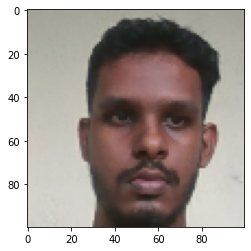

In [7]:
img = preprocess("data/anchor/2b45094a-efc4-11ec-a2eb-6334dcaf6826.jpg")
plt.imshow(img)

In [8]:
img.numpy().max()

0.8992647

# Create labeled dataset

In [9]:
#(anchor, positive) => 1,1,1,1,1

In [10]:
positives = tf.data.Dataset.zip((anchor,positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [11]:
samples = data.as_numpy_iterator()

In [12]:
example = samples.next()

# Build Train and test partition

In [13]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img),preprocess(validation_img), label)

In [14]:
res = preprocess_twin(*example)

In [15]:
res[2]

1.0

In [16]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [17]:
samples = data.as_numpy_iterator()

In [18]:
samp = samples.next()

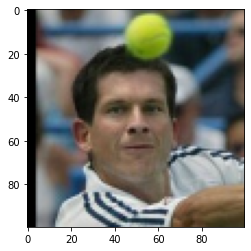

In [19]:
plt.imshow(samp[1])

In [20]:
samp[2]

0.0

In [21]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [22]:
train_samples = train_data.as_numpy_iterator()

In [23]:
train_sample = train_samples.next()

In [24]:
len(train_sample[0])

16

In [25]:
# Testing partition
test_data = data.skip(round(len(data)*.7))

test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [26]:
test_samples = test_data.as_numpy_iterator()

In [27]:
test_sample = test_samples.next()

In [28]:
len(test_sample[0])

16

# (Source Code) Model Engineering

**Build Embedding Layer**

In [29]:
def make_embedding():
    inp = Input(shape=(100,100,3),name = "input_image_layer")
    
    # First block
    c1 = Conv2D(64, (10,10),activation="relu")(inp)
    m1 = MaxPooling2D(64, (2,2),padding="same")(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7),activation="relu")(m1)
    m2 = MaxPooling2D(64,(2,2),padding="same")(c2)
    
    # Third block
    c3 = Conv2D(128,(4,4),activation="relu")(m2)
    m3 = MaxPooling2D(64,(2,2),padding="same")(c3)
    
    # Final embedding block
    c4 = Conv2D(256,(4,4),activation="relu")(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation="sigmoid")(f1)
    
    return Model(inputs=[inp],outputs=[d1],name="embedding_model")

**Build distance Layer**

In [30]:
# Siamese L1 distance class
class L1Dist(Layer):
    
    # init method - Inheritance
    def __init__(self, **kwargs):
        super().__init__()
        
    # similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding-validation_embedding)
    

In [31]:
siamese_layer = L1Dist()

**Make siamese model**

In [39]:
def make_siamese_model():
    # Anchor image input in the network
    input_image = Input(name="Input_img", shape=(100,100,3))
    
    # Validation image in the network
    validation_image = Input(name="validation_img", shape=(100,100,3))
        
    embedding = make_embedding()
    
    # Combine siamese distance layer components
    
    siamese_layer._name = "distance"
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer
    classifier = Dense(1, activation="sigmoid")(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier,name="siameseNetwork")

In [40]:
siamese_model = make_siamese_model()

# Training #

**Setup loss and optimizer** 

In [41]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [42]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

**Establish checkpoints**

In [43]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt,siamese_model=siamese_model)

In [44]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        # get anchor and positive/negative image
        x = batch[:2]
        # get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(x, training=True)
        # calculation
        loss = binary_cross_loss(y, yhat)
    print(loss)
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

**Build training loop**

In [45]:
def train(data, EPOCHS):
    # loop through epochs
    for epoch in range(1, EPOCHS + 1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(train_data))

        # Loop through each batch
        for idx, batch in enumerate(train_data):
            # run train step here
            train_step(batch)
            progbar.update(idx + 1)
        # save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)


**Train the model**

In [57]:
EPOCHS = 50

In [58]:
#train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 29s 1s/step

 Epoch 2/50
27/27 [==============================] - 28s 1s/step

 Epoch 3/50
27/27 [==============================] - 28s 1s/step

 Epoch 4/50
27/27 [==============================] - 38s 1s/step

 Epoch 5/50
27/27 [==============================] - 33s 1s/step

 Epoch 6/50
27/27 [==============================] - 32s 1s/step

 Epoch 7/50
27/27 [==============================] - 32s 1s/step

 Epoch 8/50
27/27 [==============================] - 32s 1s/step

 Epoch 9/50
27/27 [==============================] - 33s 1s/step

 Epoch 10/50
27/27 [==============================] - 35s 1s/step

 Epoch 11/50
27/27 [==============================] - 34s 1s/step

 Epoch 12/50
27/27 [==============================] - 35s 1s/step

 Epoch 13/50
27/27 [==============================

# Evaluate Model #

In [48]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [49]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [50]:
# Make predictions
y_hat = siamese_model.predict([test_input,test_val])
y_hat

1/1 [==============================] - 1s 521ms/step


array([[0.50014603],
       [0.49949765],
       [0.5003591 ],
       [0.50030595],
       [0.50041014],
       [0.5001043 ],
       [0.50019294],
       [0.5007144 ],
       [0.5000195 ],
       [0.5000281 ],
       [0.49916345],
       [0.5000985 ],
       [0.5002323 ],
       [0.50052005],
       [0.50017786],
       [0.49995908]], dtype=float32)

In [62]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1]

In [63]:
y_true

array([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
      dtype=float32)

In [77]:
# Creating metric object
m = Recall()

# calculating the recall value
m.update_state(y_true, y_hat)

# Return recall result
m.result().numpy()

1.0

In [65]:
# Creating precision object
p = Precision()

# calculating the precision value
p.update_state(y_true, y_hat)

# Return precisionresult
p.result().numpy()

1.0

# Visualize results #

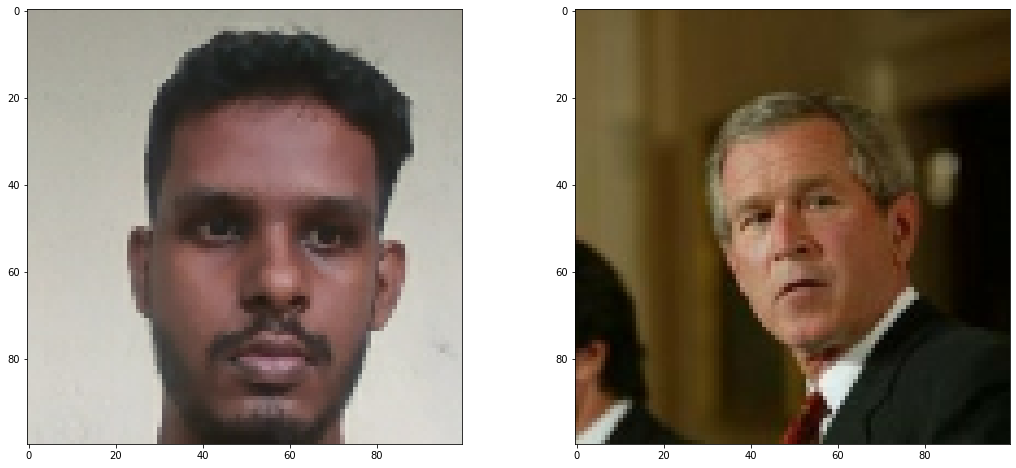

In [66]:
# Set plot size
plt.figure(figsize=(18,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[1])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])
plt.show()

# Save Model #

In [67]:
#siamese_model.save("siamesemodel.h5")

In [51]:
# Reload model
model = tf.keras.models.load_model('siamesemodel.h5',
                                 custom_objects={'L1Dist':L1Dist,
                                                 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [52]:
pred = model.predict([test_input, test_val])

1/1 [==============================] - 0s 434ms/step


In [53]:
# Creating precision object
p = Precision()

# calculating the precision value
p.update_state(y_true, pred)

# Return precisionresult
p.result().numpy()

1.0

# Real time test #

**Verification function**

In [74]:
def verify(frame, model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join("application_data","verification_images")):
        input_img = preprocess(os.path.join("application_data", "input_image","input_image.jpg"))
        validation_img = preprocess(os.path.join("application_data", "verification_images",image))
        
        result = model.predict(list(np.expand_dims([input_img, validation_img]), axis=1))
        results.append(result)
        
    detection = np.sum(np.array(results)> detection_threshold)
    verification = detection / len(os.listdir(os.path.join("application_data", "verification_images")))
    verified = verification > verification_threshold
    
    return results, verified
    
    
    # Detection THreshold: Metric above which a prediction is considered positive
    # Verification THreshold: Propostion of positive predictions / total positive samples

# Real time verification #

In [76]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    ret, frame = cap.read()
    
    cv2.imshow("verification", frame)
    
    if cv2.waitkey(10) & 0xFF == ord("q"):
        break
cap.release()
cv2.destroyAllWindows()

[ WARN:0@2228.085] global /io/opencv/modules/videoio/src/cap_v4l.cpp (902) open VIDEOIO(V4L2:/dev/video1): can't open camera by index


error: OpenCV(4.6.0) /io/opencv/modules/highgui/src/window.cpp:1261: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'
